In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFddMnBqT6APkQ5OzOUGZL7UDeAvSfo46zD49-LCw8FveI7ItAyArM
Mounted at /content/drive/


In [4]:
df = pd.read_csv('drive/My Drive/nyc_energy_consumption.csv', parse_dates=True)
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [5]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [6]:
df.dtypes

timeStamp    datetime64[ns]
demand              float64
precip              float64
temp                float64
dtype: object

In [7]:
df = df.set_index('timeStamp')

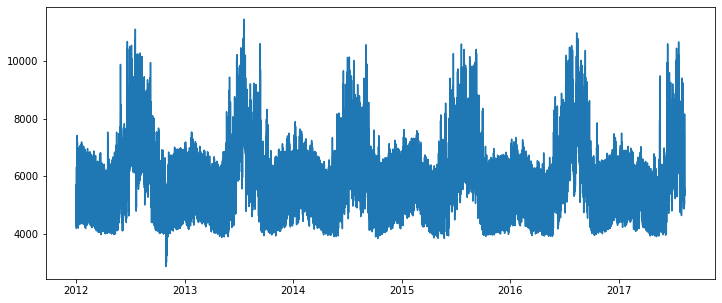

In [8]:
plt.figure(figsize = (12, 5))

plt.plot(df['demand'])
plt.show()

In [9]:
df = df.resample('D').mean()

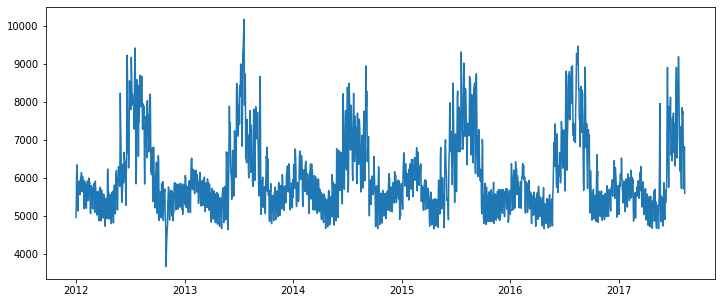

In [10]:
plt.figure(figsize = (12, 5))

plt.plot(df['demand'])
plt.show()

In [11]:
df_final = df.reset_index()[['timeStamp', 'demand', 'temp']].rename({'timeStamp' : 'ds', 'demand' : 'y', 'temp' : 'temp'}, axis = 'columns')

In [12]:
df_final.head()

,ds,y,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500


In [13]:
df_final.query('temp != temp')

,ds,y,temp
1457,2015-12-28,5510.776333,NaN


In [14]:
df_final['temp'] = df_final['temp'].fillna(method = 'ffill')

In [15]:
df_final.query('temp != temp')

,ds,y,temp


In [16]:
df_final['month'] = df_final['ds'].dt.month

In [17]:
df_final.head()

,ds,y,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1


<br/>

## Seeing the outliers

In [18]:
px.line(df_final, x='ds', y='y', hover_data=['temp','month'], title='NYC Energy Demand')

<br/>

## Group the **temp** feature by **month**

In [19]:
df_final[['month', 'temp']].groupby('month').agg({'temp' : {'mean', 'max', 'min'}})

temp                      
             min        max       mean
month                                 
1       9.507917  55.420455  33.432140
2       9.015000  59.360000  34.517758
3      20.291667  67.878333  41.419884
4      33.045833  72.992083  52.600204
5      48.090833  82.576250  62.543994
6      52.405833  86.916667  71.334418
7      66.417083  89.606667  77.595627
8      68.042083  87.426250  75.525947
9      57.274583  84.448750  69.550306
10     42.106250  74.277500  58.642895
11     27.172500  67.606250  47.225638
12     22.429583  64.735000  41.520068

In [20]:
df_final[['y', 'temp']].corr()

,y,temp
y,1.000000,0.560888
temp,0.560888,1.000000


In [21]:
df_final.query('temp > 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.552918
temp,0.552918,1.000000


In [22]:
df_final.query('temp < 80')[['y', 'temp']].corr()

,y,temp
y,1.000000,0.470562
temp,0.470562,1.000000


In [23]:
def summer_temp(temp):

  if temp>80:
    return 1
  else:
    return 0

df_final['Summer_temp'] = df_final['temp'].apply(summer_temp)

In [24]:
df_final.head()

,ds,y,temp,month,Summer_temp
0,2012-01-01,4954.833333,46.510000,1,0
1,2012-01-02,5302.954167,40.496667,1,0
2,2012-01-03,6095.512500,26.672500,1,0
3,2012-01-04,6336.266667,20.585000,1,0
4,2012-01-05,6130.245833,33.577500,1,0


In [25]:
df_final['month_bins'] = pd.cut(df_final['month'], bins = 3, labels = False)

In [26]:
df_final.head()

,ds,y,temp,month,Summer_temp,month_bins
0,2012-01-01,4954.833333,46.510000,1,0,0
1,2012-01-02,5302.954167,40.496667,1,0,0
2,2012-01-03,6095.512500,26.672500,1,0,0
3,2012-01-04,6336.266667,20.585000,1,0,0
4,2012-01-05,6130.245833,33.577500,1,0,0


In [27]:
df_final['month_bins'].unique()

array([0, 1, 2])

In [28]:
train = df_final[(df_final['ds'] >= '2012-01-01') & (df_final['ds'] <= '2017-04-30')]
test = df_final[(df_final['ds'] > '2017-04-30')]

In [29]:
print("Train shape : {}".format(train.shape))
print("Test shape : {}".format(test.shape))

Train shape : (1947, 6)
Test shape : (104, 6)


In [30]:
test['Summer_temp'].unique()

array([0, 1])

In [31]:
model = Prophet(interval_width= 0.95, yearly_seasonality= True)

In [32]:
model.add_regressor('Summer_temp', standardize=False)
model.add_regressor('month_bins', standardize = False, mode = 'multiplicative')

In [33]:
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
model.params

OrderedDict([('k', array([[0.14760422]])),
             ('m', array([[0.58876607]])),
             ('delta',
              array([[-4.71416526e-08, -6.41586311e-06, -1.82744926e-01,
                      -1.67782383e-07, -1.74103167e-08,  1.22142120e-02,
                       7.69355196e-03,  2.98750794e-03,  9.89830150e-08,
                       3.31189176e-08, -3.32094703e-08, -3.81719061e-02,
                      -2.42237664e-05,  7.15586204e-08,  1.40721628e-01,
                       3.60042834e-07, -3.04861026e-07, -9.94059548e-02,
                      -4.33196683e-02,  3.01139014e-08,  6.19431008e-08,
                       5.68495201e-08,  3.76665581e-02,  2.84149406e-02,
                       1.32793754e-07]])),
             ('sigma_obs', array([[0.03884209]])),
             ('beta',
              array([[-0.03548167, -0.05910135,  0.04945314,  0.04015359, -0.00950002,
                      -0.00176236, -0.007792  , -0.00252906,  0.00343317, -0.00585251,
                 

In [35]:
future = model.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [36]:
future['Summer_temp'] = df_final['Summer_temp']
future['month_bins'] = df_final['month_bins']
future

,ds,Summer_temp,month_bins
0,2012-01-01,0,0
1,2012-01-02,0,0
2,2012-01-03,0,0
3,2012-01-04,0,0
4,2012-01-05,0,0
...,...,...,...
2046,2017-08-08,0,1
2047,2017-08-09,0,1
2048,2017-08-10,0,1
2049,2017-08-11,0,1


In [37]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7383.695055,6644.272091,8094.852414
2047,2017-08-09,7394.540415,6632.091661,8209.678076
2048,2017-08-10,7364.877855,6626.643462,8120.694201
2049,2017-08-11,7314.672167,6540.895381,8052.764410
2050,2017-08-12,6733.792052,6005.161115,7504.250842


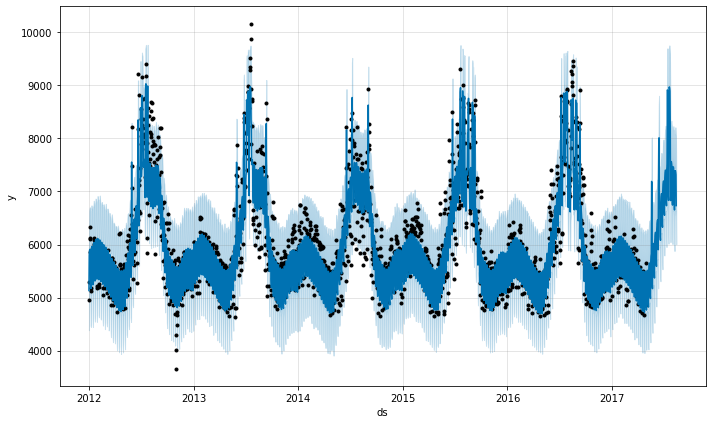

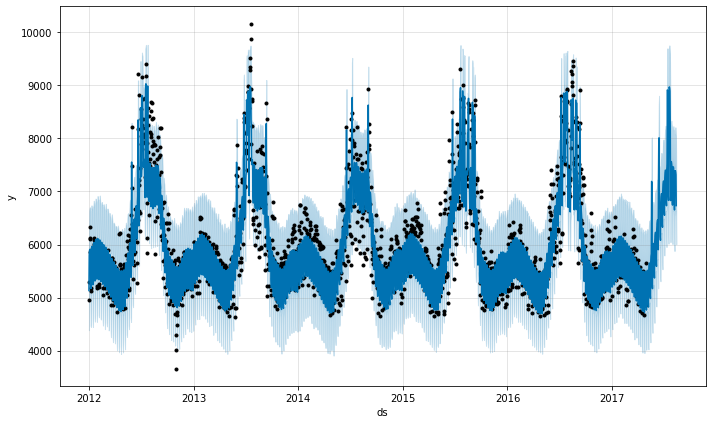

In [38]:
model.plot(forecast)

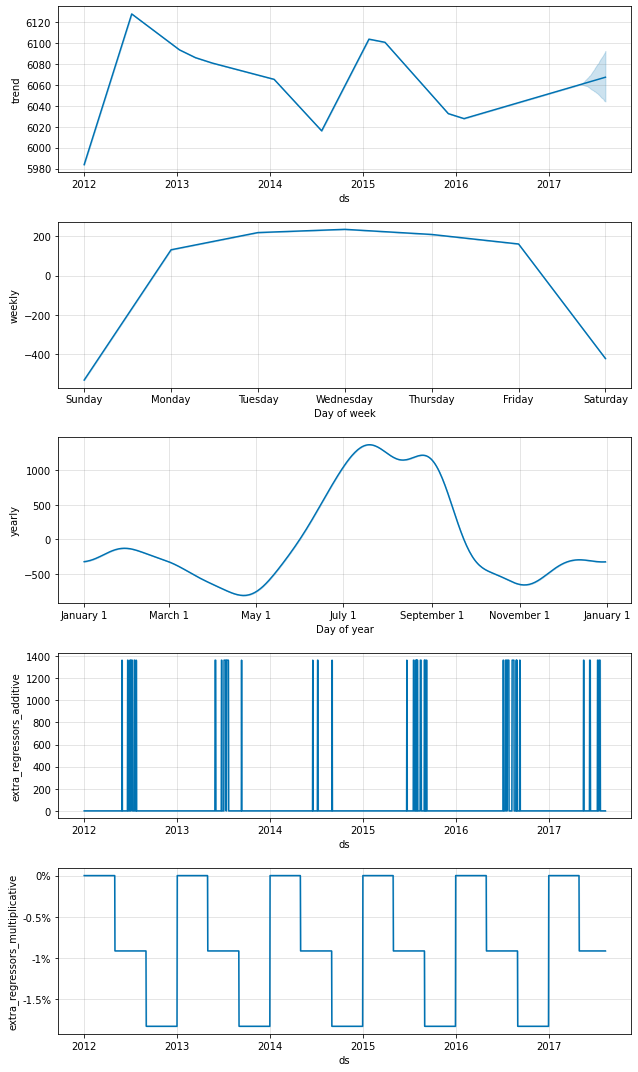

In [39]:
model.plot_components(forecast)
plt.show()

In [40]:
cv_results = cross_validation( model = model, initial = '731 days', horizon = '365 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,204293.922864,451.988853,352.610429,0.062543,0.051056,0.901099
1,37 days 00:00:00,210424.439085,458.720437,359.614485,0.063723,0.051274,0.890110
2,37 days 12:00:00,211653.376540,460.058014,361.875027,0.064102,0.051798,0.890110
3,38 days 00:00:00,215758.752010,464.498388,365.841034,0.064497,0.053251,0.884615
4,38 days 12:00:00,217944.760867,466.845543,369.633793,0.065097,0.054411,0.884615
...,...,...,...,...,...,...,...
653,363 days 00:00:00,156476.433386,395.571022,334.336980,0.061215,0.060978,0.983516
654,363 days 12:00:00,156952.382181,396.172162,334.121377,0.061178,0.060978,0.983516
655,364 days 00:00:00,160084.466586,400.105569,336.855265,0.061888,0.061735,0.978022
656,364 days 12:00:00,159558.111682,399.447258,335.652320,0.061691,0.061467,0.978022


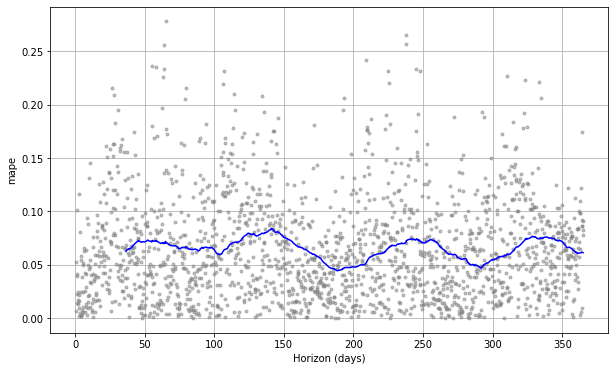

In [41]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mape')